In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/notebooks/JAXGym")

In [3]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

from flax.training.train_state import TrainState

import gymnax
import brax

import matplotlib.pyplot as plt

In [4]:
from models.base_model import BaseModel, NormalDistPredictor

# from agents.REINFORCE_continuous import ActorCriticContinuous
from agents.PPO import PPOContinuous
from agents.advantage_estimator import state_value_estimator, gae_estimator

from trainer import build_trainer

from utils.callback import tqdm_callback

In [5]:
actor_lr = 2e-4
critic_lr = 2e-3

discount = 0.9

clip_ratio = 0.95
ppo_steps = 4

num_envs = 8

iters = 1000

max_episode_steps = 500

env_name = "hopper"
backend = "positional"

In [6]:
# https://github.com/luchris429/purejaxrl/blob/5343613b07b3bc543c49695df601fc40f5ec3062/purejaxrl/wrappers.py#L117

from gymnax.environments import environment, spaces
from brax.envs.wrappers.training import EpisodeWrapper, AutoResetWrapper

class BraxGymnaxWrapper:
    def __init__(self, env_name, backend="positional"):
        env = envs.get_environment(env_name=env_name, backend=backend)
        env = EpisodeWrapper(env, episode_length=1000, action_repeat=1)
        env = AutoResetWrapper(env)
        self._env = env
        self.action_size = env.action_size
        self.observation_size = (env.observation_size,)

    def reset(self, key, params=None):
        state = self._env.reset(key)
        return state.obs, state

    def step(self, key, state, action, params=None):
        next_state = self._env.step(state, action)
        return next_state.obs, next_state, next_state.reward, next_state.done > 0.5, {}

    def observation_space(self, params):
        return spaces.Box(
            low=-jnp.inf,
            high=jnp.inf,
            shape=(self._env.observation_size,),
        )

    def action_space(self, params):
        return spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(self._env.action_size,),
        )

In [7]:
from brax import envs

env, env_params = BraxGymnaxWrapper(env_name), None

obs_size = env.observation_space(env_params).shape[0]
action_size = env.action_space(env_params).shape[0]

In [8]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]

with jax.default_device(gpu_device):
    key = jax.random.PRNGKey(64)
    
    dummy = jnp.ones([1, obs_size])
    actor_init_key, critic_init_key, key = jax.random.split(key, 3)
    
    actor_model = nn.Sequential([BaseModel(hidden_size = 128, num_layers = 4), NormalDistPredictor(output_size = action_size, logvar_init_value = 0, limits = (-1, 1))])
    actor_params = actor_model.init(actor_init_key, dummy)['params']
    actor_tx = optax.adam(actor_lr)
    actor = TrainState.create(apply_fn=actor_model.apply,
                              params=actor_params,
                              tx=actor_tx,
                              )
    
    critic_model = nn.Sequential([BaseModel(hidden_size = 128, num_layers = 4), nn.Dense(features = 1)])
    critic_params = critic_model.init(critic_init_key, dummy)['params']
    critic_tx = optax.adam(critic_lr)
    critic = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params,
                              tx=critic_tx,
                              )
    
    agent = PPOContinuous(gae_estimator(discount, 0.95), clip_ratio, ppo_steps)
    
    logger = jnp.zeros((iters, 1))

    fori_body = build_trainer(agent, env, env_params, num_envs, obs_size, action_size, max_episode_steps, tqdm_callback(iters))
    
    carry = (actor, critic, logger, key)
    carry = jax.lax.fori_loop(0, iters, fori_body, carry)

  0%|          | 0/1000 [00:00<?, ?it/s]

(8, 3)


100%|██████████| 1000/1000 [12:13<00:00,  1.41it/s, Reward=1336.8867]

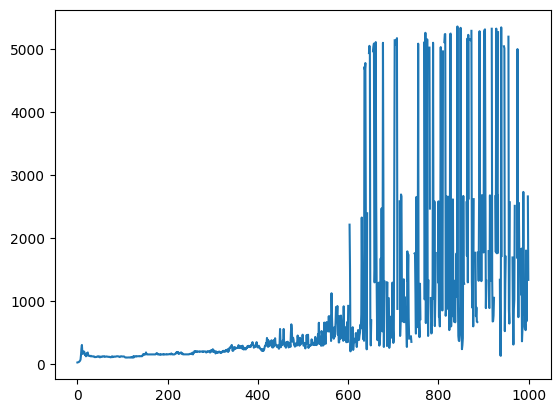

In [9]:
plt.clf()
plt.gca().set_aspect('auto')
plt.plot(carry[-2][:])
plt.show()

In [10]:
from IPython.display import HTML

from brax.io import html
from tqdm.notebook import tqdm

actor = carry[0]

env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(lambda obs: agent.suggest_action(obs, actor))

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in tqdm(range(1000)):
    rollout.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act = jit_inference_fn(state.obs)
    state = jit_env_step(state, act)

HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

  0%|          | 0/1000 [00:00<?, ?it/s]